In [33]:
import os
import itertools
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
from simulator_utilities import *
np.random.seed(7)

In [45]:
# ========================
# Preparation
# ========================
# Output
folder_path = r'/mnt/c/w/repos/slate_sim/data/'
summary_file_path = os.path.join(folder_path, 'simulation_data_summary.csv')
context_file_path = os.path.join(folder_path, 'simulation_data_{0}.csv')

# Contexts 
contexts = {'platform': ['Mac', 'Windows'], 
            'network': ['wifi', 'wired'], 
            'country': ['US', 'CA']}
unique_contexts = [list(x) for x in itertools.product(*contexts.values())]

# Parameter statistics
params = {
          'x': {'mean': 1, 'min': 0, 'max': 4, 'std_range': [0.1, 1.1]},
          'y': {'mean': 1, 'min': 0, 'max': 3, 'std_range': [0.1, 1.1]}, 
          'z': {'mean': 1, 'min': 0, 'max': 2, 'std_range': [0.1, 1.1]}
         }

# Initialization
data = []
dist_context = {}
reward_range = [0.05, 0.35]
coefficient_range = [0.1, 1]
interaction2 = True
known_n = None # None, 20
descritization_policy = {'x': 8, 'y': 6, 'z': 4}
share_descritized_grid = True

# Confidence Interval statistics
ci_mean = 0
ci_std = 0.00001
ci_dist = gen_distribution('normal', ci_mean, ci_std, 5000)[0]

# N for each unique context
if known_n:
    n_per_config = known_n
else:
    ci_width = 0.005
    ci_mult = 1.96
    n_per_config = int(((ci_mult*ci_std/(ci_width/2))**2//100+1)*100)
n_per_context = np.prod([x if isinstance(x, int) else len(x)for x in descritization_policy.values()]) * n_per_config
print('Data Size per Configuration: {:,}'.format(n_per_config))
print('Data Size per Context: {:,}'.format(n_per_context))
print('Total Data Size: {:,}'.format(n_per_context*len(unique_contexts)))

Data Size per Configuration: 100
Data Size per Context: 19,200
Total Data Size: 153,600


In [14]:
# all_gamma_params = []

**[1/8] Generating data for context ['Mac', 'wifi', 'US'] ...**

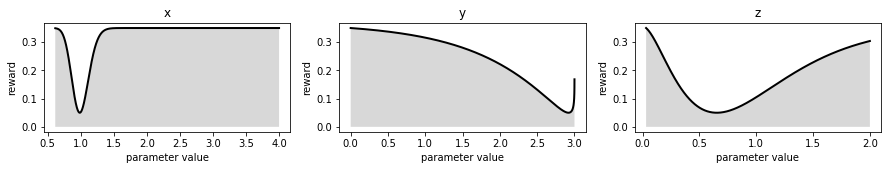

* reward = 0.1202x + 0.6352y + 0.9683z + 0.1771xy + 0.1835xz + 0.8002yz

**[2/8] Generating data for context ['Mac', 'wifi', 'CA'] ...**

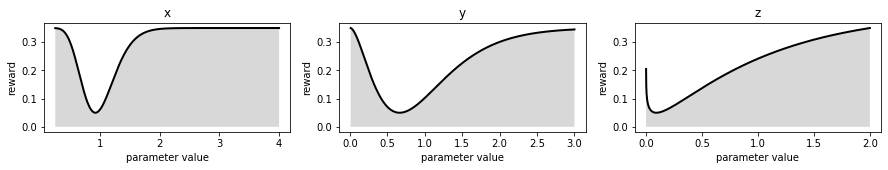

* reward = 0.7152x + 0.1859y + 0.7132z + 0.4747xy + 0.7526xz + 0.8426yz

**[3/8] Generating data for context ['Mac', 'wired', 'US'] ...**

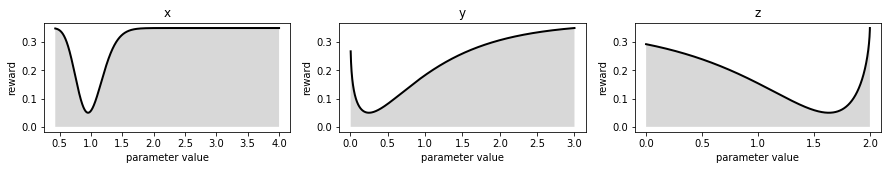

* reward = 0.902x + 0.592y + 0.3316z + 0.5242xy + 0.6546xz + 0.3708yz

**[4/8] Generating data for context ['Mac', 'wired', 'CA'] ...**

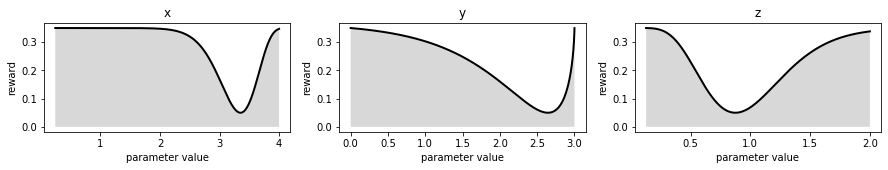

* reward = 0.6352x + 0.3304y + 0.7964z + 0.9457xy + 0.3949xz + 0.1228yz

**[5/8] Generating data for context ['Windows', 'wifi', 'US'] ...**

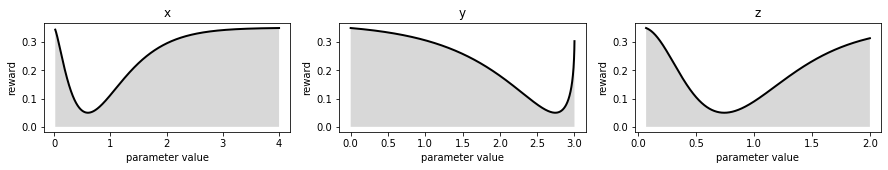

* reward = 0.6627x + 0.2226y + 0.4658z + 0.4108xy + 0.5329xz + 0.528yz

**[6/8] Generating data for context ['Windows', 'wifi', 'CA'] ...**

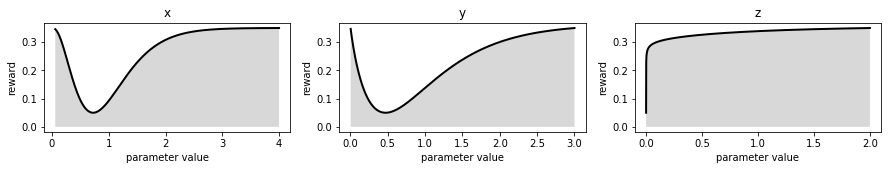

* reward = 0.8234x + 0.7319y + 0.2652z + 0.2279xy + 0.6133xz + 0.8102yz

**[7/8] Generating data for context ['Windows', 'wired', 'US'] ...**

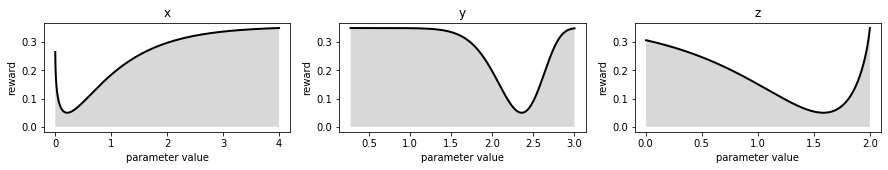

* reward = 0.1539x + 0.4186y + 0.1544z + 0.9446xy + 0.1296xz + 0.5676yz

**[8/8] Generating data for context ['Windows', 'wired', 'CA'] ...**

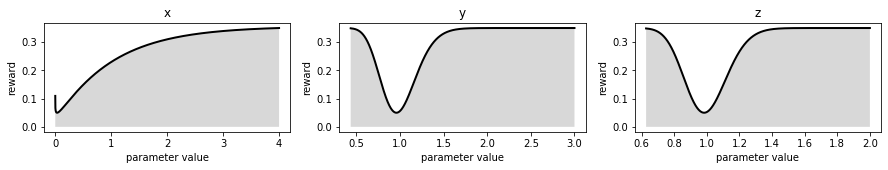

* reward = 0.736x + 0.2177y + 0.4323z + 0.9179xy + 0.6394xz + 0.8028yz

In [46]:
# ========================
# Generate data
# ========================
param_list = list(params.keys())
df_cols = list(contexts.keys()) + param_list + ['reward']
plot_pairs = [x for x in itertools.combinations(range(len(param_list)), 2)]
df_summary = pd.DataFrame()
df_all = pd.DataFrame()
coeff_all = [[0.12019595, 0.63518419, 0.96830226, 0.17708101, 0.18345325,0.8002412 ],
    [0.71518135, 0.18591909, 0.71323735, 0.47473797, 0.7525629 ,0.84263121],
    [0.90204983, 0.59199671, 0.33160712, 0.52421906, 0.65463157,0.37078185],
    [0.63522404, 0.33039906, 0.79644431, 0.94571491, 0.39494207, 0.12283538],
    [0.66273394, 0.22264627, 0.46584369, 0.41080309, 0.53285229,0.52803675],
    [0.82335403, 0.73190862, 0.26517287, 0.22790234, 0.61333563, 0.81023372],
    [0.15385043, 0.41863797, 0.15437206, 0.94464021, 0.12960767,0.567603  ],
    [0.73596655, 0.21766755, 0.43232531, 0.91792597, 0.63940162,0.80277422]]

gamma_param_all = [[0.12581686354841784, 0.9587723672104524, 0.5892252321817967],
[0.28456932884715136, 0.5794502415871884, 0.9530046583259941],
[0.21186398865555958, 0.8676770694338504, 0.7956440151232661],
[0.3327167704629427, 0.8020849264958928, 0.3534171495668579],
[0.6329803095169089, 0.8613506489399466, 0.5079810486234102],
[0.5244209894315414, 0.7256607308940456, 1.0952626583098724],
[0.8866024334344276, 0.2883860159703292, 0.7626985026756992],
[0.983667875614948, 0.20293592013287434, 0.12741018214844926]
]

if share_descritized_grid:
    for k, v in descritization_policy.items():
        if isinstance(v, int):
            descritization_policy[k] = [round(x,4) for x in np.linspace(params[k]['min'], params[k]['max'], v)]
            
for run in np.arange(1):
    for i, c in enumerate(unique_contexts):

        display(Markdown('**[{0}/{1}] Generating data for context {2} ...**'.format(i+1, len(unique_contexts), c)))

        # [1] Generate Distributions
        n_dist = 5000
#         dist_context[i], gamma_params = gen_param_reward(params, reward_range, n_dist, None)
#         print(dist_context[i]["x"])
#         print(gamma_params)
        
        saved_gamma_param = gamma_param_all[i]   # <--------- 
#         saved_gamma_param = None                # <--------- f
        dist_context[i], gamma_params = gen_param_reward(params, reward_range, n_dist, saved_gamma_param)
#         all_gamma_params.append(gamma_params)   # <--------- f
        plot_1d_param_reward(dist_context[i])

        # [2] Coefficients
        if interaction2:
            inter_terms = [x for x in itertools.combinations(range(len(param_list)), 2)]
        else:
            inter_terms = []
        n_coef = len(param_list) + len(inter_terms)
#         coefficients = np.random.uniform(coefficient_range[0], coefficient_range[1], n_coef)
#         coeff_all.append(coefficients)
        coefficients = coeff_all[i]

        # [3] Discretize parameter
        discretize_parameters(dist_context[i], descritization_policy, equal_distance=True)
        dist_context[i]['configs'] = gen_config_reward(dist_context[i], param_list)

        # [4] Reward formula
        reward_formula = param_list + ['{0}{1}'.format(param_list[x[0]], param_list[x[1]]) for x in inter_terms]
        dist_context[i]['configs']['reward_equation'] = formulate_equation(reward_formula, coefficients)
        dist_context[i]['configs']['config_rterms'] = add_interactions(dist_context[i]['configs']['config_rterms'], inter_terms)
        display(Markdown('* {0}'.format(dist_context[i]['configs']['reward_equation'])))

        # [5] Generate data
        num_values = gen_data(dist_context[i], n_per_config, ci_dist, coefficients, reward_range)
        dist_context[i]['configs']['config_reward'] = np.array([x[-1] for x in num_values])
        c_data = [c + list(x) for x in num_values]
        data = data + c_data

        # [6] Plot 2D
        plot_data = pd.DataFrame(num_values, columns=param_list + ['reward'])
#         plot_2d_paris(plot_data, param_list, inter_terms, round_to=0.05)

        # [7] To file
        df_context = pd.DataFrame(c_data, columns=df_cols)
        df_context = df_context.sample(frac=1)
        df_context['run'] = run
    #     df_context.to_csv(context_file_path.format(c), index=False)
        df_all = df_all.append(df_context)

        # [8] Summary
        df_mean = summarize_df(df_context, param_list, c)
        df_summary = df_summary.append(df_mean)

In [29]:
df_all.run.unique()

array([0])

In [47]:
moniker = "8_6_4_00001"
out_path = os.path.join(folder_path, f"df_all_{moniker}.csv")
summary_out_path = os.path.join(folder_path, f"df_all_{moniker}_summary.csv")
df_all.to_csv(out_path)
df_summary.to_csv(summary_out_path, index=False)

In [18]:
coeff_all

NameError: name 'coeff_all' is not defined

In [ ]:
coeff_all

In [ ]:
# 4-3-2 ground truth
min_actions = {}
min_reward = {}
grps_run = df_all.groupby(['run'])
for run in grps_run.groups.keys():
    df_temp = grps_run.get_group(run)
    grps = df_temp.groupby(['platform', 'network', 'country'])
    for grp in grps.groups.keys():
        if grp not in min_actions.keys():
            min_actions[grp] = {}
            min_reward[grp] = []
        temp_grp = grps.get_group(grp)
        temp_min = temp_grp['reward'].min()
        for action in ['x', 'y', 'z']:
            if action not in min_actions[grp].keys():
                min_actions[grp][action] = []
        min_actions[grp]['x'].append(df_temp[df_temp['reward'] == temp_min][['x','y','z']].drop_duplicates().values[:,0])
        min_actions[grp]['y'].append(df_temp[df_temp['reward'] == temp_min][['x','y','z']].drop_duplicates().values[:,1])
        min_actions[grp]['z'].append(df_temp[df_temp['reward'] == temp_min][['x','y','z']].drop_duplicates().values[:,2])
        min_reward[grp].append(temp_min)
        print(grp, temp_min, df_temp[df_temp['reward'] == temp_min][['x','y','z']].drop_duplicates().values)

In [ ]:
for key in min_actions.keys():
    print(key)
    print(np.mean(min_actions[key]['x']))
    print(np.mean(min_actions[key]['y']))
    print(np.mean(min_actions[key]['z']))

In [ ]:
min_reward

In [19]:
df_summary.to_csv(summary_file_path, index=False)

In [ ]:
df_summary